
<div align="right" style="text-align: right"><i>Peter Norvig<br>2014<br>Python 3, 2020</i></div>

<center>
<h1>How To Do Things With Words  (And Counters)
<br><font color=blue>or</font>
<br>Statistical Natural Language Processing in Python
<br><font color=blue>or</font>
    <br>Everything I Needed to Know I learned From Sesame Street</h1>
<br>
<br><img src='http://norvig.com/ipython/the-count.jpg'> 
<br><i>One, two, three, ah, ah, ah! &mdash; The Count</i>
</center>
<hr>
    
This notebook will look at data, models, and tasks involving stastical natural language processing.
    
First some boring preliminaries:

In [1]:
import re
import math
import random
import matplotlib.pyplot as plt
from collections import Counter
from itertools   import permutations
from functools   import lru_cache
from typing      import List, Tuple, Set, Dict, Callable

Word = str    # We implement words as strings
cat = ''.join # Function to concatenate strings together

# Data: Text and Words

Before we can do things with words, we need some words.  I happen to have a big text called [big.txt](big.txt).  We can read it, and see how big it is (in characters):

In [2]:
TEXT = open('big.txt').read()
len(TEXT)

6488409

Over six million characters.

Now break the characters into words (or more formal-sounding: *tokens*).  We'll ignore capitalization and punctuation and anything but the 26 letters (other tokenizers *do* deal with such things). The function `tokens` turns text into a list of words, and `sentence` puts tokens back together into a string:

In [3]:
def tokens(text) -> List[Word]:
    """List all the word tokens (consecutive letters) in a text. Normalize to lowercase."""
    return re.findall('[a-z]+', text.lower()) 

sentence = ' '.join # Function to join words with spaces

In [4]:
tokens('This is: "A test". 😋')

['this', 'is', 'a', 'test']

In [5]:
sentence(tokens('This is: "A test". 😋'))

'this is a test'

How many words are in the text?

In [6]:
WORDS = tokens(TEXT)
len(WORDS)

1105211

Over a million words.  Here are the first 10:

In [7]:
sentence(WORDS[:10])

'the project gutenberg ebook of the adventures of sherlock holmes'

# Model: The Bag of Words Model

`WORDS` is a list of the words in `TEXT`, and with a little work it can also serve as a *generative model* of text. We know that language is very complicated, but we can create a simplified model of language that captures part of the complexity.  

In the so-called [**bag of words** model](https://en.wikipedia.org/wiki/Bag-of-words_model), we ignore the order of words, but maintain their frequency.  Think of it this way: take all the words from the text, and throw them into a bag.  Shake the bag, and then generate a sentence by pulling words out of the bag one at a time.  Chances are the "sentence" won't be grammatical or sensible, but it will have words in roughly the right proportions.  Here we generate a "sentence" with this approach:

In [8]:
def sample(words, n=10) -> str:
    """Sample n random words from a list of words."""
    return [random.choice(words) for _ in range(n)]

In [9]:
sentence(sample(WORDS))

'sore the toes debt my after interference struggle the moment'

`WORDS` is a million elements list, and has a lot of repetition. For example:

In [10]:
WORDS.count('the')

80029

A more compact representation for a bag of words is a `collections.Counter`: a dictionary of `{'word': count}` entries (with some handy extra [methods](https://docs.python.org/3/library/collections.html#collections.Counter)).  We could use `Counter` directly, but I will define `Bag` as a subclass of Counter (note that [bag](https://en.wikipedia.org/wiki/Multiset) is considered a synonym of [multiset](https://en.wikipedia.org/wiki/Multiset)):

In [11]:
class Bag(Counter): """A bag of words."""

In [12]:
Bag(tokens('Is this a test? It is a test! A test it is!'))

Bag({'is': 3, 'this': 1, 'a': 3, 'test': 3, 'it': 2})

Let's make a `Bag` of `WORDS` and get a feel for what's there:

In [13]:
BAG = Bag(WORDS)

len(BAG) # Number of different words

29152

In [14]:
BAG.most_common(20) # Most common words

[('the', 80029),
 ('of', 40025),
 ('and', 38312),
 ('to', 28766),
 ('in', 22047),
 ('a', 21155),
 ('that', 12512),
 ('he', 12401),
 ('was', 11410),
 ('it', 10681),
 ('his', 10034),
 ('is', 9774),
 ('with', 9740),
 ('as', 8064),
 ('i', 7682),
 ('had', 7383),
 ('for', 6938),
 ('at', 6791),
 ('by', 6738),
 ('on', 6643)]

# Model: Zipf's Law

In 1935, linguist George Zipf observed that in any big text, the *n*th most frequent word appears with a frequency of roughly 1/*n* of the most frequent word. He get's credit for [*Zipf's Law*](https://en.wikipedia.org/wiki/Zipf%27s_law), even though [Felix Auerbach](https://en.wikipedia.org/wiki/Felix_Auerbach) made a similar observation in 1913.  If we plot the frequency of words, most common first, on a log-log plot, they should come out as a straight line if Zipf's Law holds.  Here we see that it is a fairly close fit:

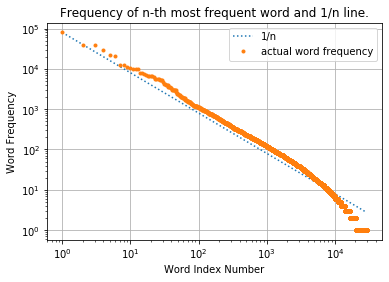

In [15]:
def zipf_plot(bag):
    M = max(bag.values()) # Count for most common word
    X = range(1, len(bag) + 1)
    plt.yscale('log'); plt.xscale('log'); 
    plt.title('Frequency of n-th most frequent word and 1/n line.')
    plt.xlabel('Word Index Number'); plt.ylabel('Word Frequency')
    plt.plot(X, [M/i for i in X], ':', label='1/n')
    plt.plot(X, [c for (w, c) in bag.most_common()], '.', label='actual word frequency')
    plt.grid(); plt.legend(loc=1)
    
zipf_plot(BAG)

# Task: Spelling Correction

Given a word *w*, find the most likely correction *c* = `correct(`*w*`)`.

**Approach:** Try all candidate words *c* that are known words that are near *w*.  Choose the most likely one.

How to balance *near* and *likely*?

For now, in a trivial way: always prefer nearer, but when there is a tie on nearness, use the word with the highest `WORDS` count.  Measure nearness by *edit distance*: the minimum number of deletions, transpositions, insertions, or replacements of characters. By trial and error, we determine that going out to edit distance 2 will give us reasonable results.  Then we can define `correct(`*w*`)`:
        
        


In [16]:
def correct(word) -> Word:
    """Find the best spelling correction for this word."""
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known({word}) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  {word})
    return max(candidates, key=BAG.get)

The functions `known` and `edits0` are easy; and `edits2` is easy if we assume we have `edits1`:

In [17]:
def known(words) -> Set[Word]:
    """Return the subset of `words` that are in the known `BAG` of words."""
    return words.intersection(BAG)

def edits2(word) -> Set[str]:
    """Return all strings that are two edits away from this word."""
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

Now for `edits1(word)`: the set of candidate words that are one edit away. For example, given `"wird"`, this would include `"weird"` (inserting an `e`) and `"word"` (replacing a `i` with a `o`), and also `"iwrd"` (transposing `w` and `i`; then `known` can be used to filter this out of the set of final candidates). How could we get them?  One way is to *split* the original word in all possible places, each split forming a *pair* of words, `(a, b)`, before and after the place, and at each place, either delete, transpose, replace, or insert a letter:

<table>
  <tr><td> pairs: <td><tt> Ø, wird <td><tt> w, ird <td><tt> wi, rd <td><tt>wir, d<td><tt>wird, Ø<td><i>Notes:</i><tt> (<i>a</i>, <i>b</i>)</tt> pair</i>
  <tr><td> deletions: <td><tt>Ø+ird<td><tt> w+rd<td><tt> wi+d<td><tt> wir+Ø<td><td><i>Delete first char of b</i>
  <tr><td> transpositions: <td><tt>Ø+iwrd<td><tt> w+rid<td><tt> wi+dr</tt><td><td><td><i>Swap first two chars of b
  <tr><td> replacements: <td><tt>Ø+?ird<td><tt> w+?rd<td><tt> wi+?d<td><tt> wir+?</tt><td><td><i>Replace char at start of b
  <tr><td> insertions: <td><tt>Ø+?+wird<td><tt> w+?+ird<td><tt> wi+?+rd<td><tt> wir+?+d<td><tt> wird+?+Ø</tt><td><i>Insert char between a and b
</table>

In [18]:
def edits1(word) -> Set[str]:
    """Return all strings that are one edit away from this word."""
    edits = set()
    for a, b in splits(word):
        if b: edits.add(a+b[1:])                     # deletion
        if len(b) >= 2: edits.add(a+b[1]+b[0]+b[2:]) # transposition
        for c in alphabet:
            edits.add(a+c+b[1:])                     # replacement
            edits.add(a+c+b)                         # insertion
    return edits      
    return set(deletes + transposes + replaces + inserts)

def splits(word) -> List[Tuple[str, str]]:
    """Return a list of all possible (first, rest) pairs that comprise word."""
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [19]:
splits('wird')

[('', 'wird'), ('w', 'ird'), ('wi', 'rd'), ('wir', 'd'), ('wird', '')]

In [20]:
' '.join(sorted(edits1('wird')))

'aird awird bird bwird cird cwird dird dwird eird ewird fird fwird gird gwird hird hwird iird ird iwird iwrd jird jwird kird kwird lird lwird mird mwird nird nwird oird owird pird pwird qird qwird rird rwird sird swird tird twird uird uwird vird vwird waird ward wbird wbrd wcird wcrd wdird wdrd weird werd wfird wfrd wgird wgrd whird whrd wiad wiard wibd wibrd wicd wicrd wid widd widr widrd wied wierd wifd wifrd wigd wigrd wihd wihrd wiid wiird wijd wijrd wikd wikrd wild wilrd wimd wimrd wind winrd wiod wiord wipd wiprd wiqd wiqrd wir wira wirad wirb wirbd wirc wircd wird wirda wirdb wirdc wirdd wirde wirdf wirdg wirdh wirdi wirdj wirdk wirdl wirdm wirdn wirdo wirdp wirdq wirdr wirds wirdt wirdu wirdv wirdw wirdx wirdy wirdz wire wired wirf wirfd wirg wirgd wirh wirhd wiri wirid wirj wirjd wirk wirkd wirl wirld wirm wirmd wirn wirnd wiro wirod wirp wirpd wirq wirqd wirr wirrd wirs wirsd wirt wirtd wiru wirud wirv wirvd wirw wirwd wirx wirxd wiry wiryd wirz wirzd wisd wisrd witd witrd wi

In [21]:
known(edits1('wird'))

{'bird',
 'gird',
 'sird',
 'ward',
 'weird',
 'wid',
 'wild',
 'wind',
 'wire',
 'wired',
 'wirt',
 'wiry',
 'word'}

In [22]:
len(edits2('wird'))

24254

In [23]:
s = 'Speling ERRURS in "somethink." Whutever; unusuel misteakes everyware?'

{w: correct(w) for w in tokens(s)}

{'speling': 'spelling',
 'errurs': 'errors',
 'in': 'in',
 'somethink': 'something',
 'whutever': 'whatever',
 'unusuel': 'unusual',
 'misteakes': 'mistakes',
 'everyware': 'everywhere'}

Can we make the output prettier than that? Can we preserve the punctuation and capitalization in a text?

In [24]:
def correct_text(text) -> str:
    "Correct all the words within a text, leaving the rest untouched."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match: re.Match) -> Word:
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(word) -> Callable:
    """Guess what function would give the capitalization of `word`."""
    return next(c for c in (str.upper, str.lower, str.capitalize, str)
                if c(word) == word)

In [25]:
correct_text(s)

'Spelling ERRORS in "something." Whatever; unusual mistakes everywhere?'

In [26]:
correct_text('Audiance sayzs: TUMBLR ...')

'Audience says: TUMBLER ...'

So far so good.  You can probably think of ways to make this better; we'll consider some later.

# Model: Probabilities with the Bag of Words Model

In the bag of words model, what's the probability of picking a particular word out of the bag? What's the probability of a sequence of words?

We'll denote that probability of a single word as  `Pword(word)` in Python; the probability of a sequence of words will be  `Pwords(words)`. I'll redefine `Bag` to make bags be both a Counter and a `ProbabilityFunction`: a callable object, `P`, that will give you the probability of some outcome when invoked with `P(outcome)`.

In [27]:
class ProbabilityFunction:
    def __call__(self, outcome):
        """The probability of `outcome`."""
        if not hasattr(self, 'total'):
            self.total = sum(self.values())
        return self[outcome] / self.total
    
class Bag(Counter, ProbabilityFunction): """A bag of words."""

Now the following assignment allows us to get the probability of a word with `Pword(word)`:

In [28]:
Pword = Bag(WORDS)

In [29]:
Pword('the')

0.07241060756724281

In [30]:
Pword['the']

80029

The above says that the probability of picking `the` randomly out of the bag of words is about 7%, and the actual count of `the` is 80,029. Below we see probabilities for more words:

In [31]:
sorted({(Pword(w), w) for w in tokens('''"The" is the most common word in English; 
 old-fashioned words like "victuals" and lamentations" are rare.''')})

[(9.04804602921976e-07, 'lamentations'),
 (9.04804602921976e-07, 'victuals'),
 (1.357206904382964e-05, 'fashioned'),
 (7.5098782042524e-05, 'rare'),
 (0.00019091377121653694, 'english'),
 (0.0002596789210386071, 'common'),
 (0.00026963177167074883, 'word'),
 (0.00041621011734410896, 'words'),
 (0.0008215625794531542, 'most'),
 (0.000977188971155734, 'like'),
 (0.0010676694314479317, 'old'),
 (0.0032844407086067727, 'are'),
 (0.008843560188959394, 'is'),
 (0.019948227080620804, 'in'),
 (0.03466487394714674, 'and'),
 (0.07241060756724281, 'the')]

Now, what is the probability of a *sequence* of words?  In the general case, this is defined by the definition of joint probability:

$P(w_1 \ldots w_n) = P(w_1) \times P(w_2 \mid w_1) \times \ldots P(w_n \mid w_1 \ldots w_{n-1}) =  \Pi_{i=1}^n P(w_i \mid w_1 \ldots w_{i-1})$

In the bag of words model, each word is drawn from the bag *independently* of the others.  So $P(w_i \mid w_1 \ldots w_{i-1}) = P(w_i)$, and we have:
    
$P(w_1 \ldots w_n) = P(w_1) \times P(w_2)   \times \ldots P(w_n) = \Pi_{i=1}^n P(w_i)$

Now clearly this model is wrong; the probability of a sequence of words in English *does* depend on the order of the words.  But, as the statistician George Box said,  *All models are wrong, but some are useful.*  The bag of words model, wrong as it is, has many useful applications.

<center>
    <img src="http://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/GeorgeEPBox.jpg/200px-GeorgeEPBox.jpg"> 
<br><i>All models are wrong, but some are useful<br>&mdash;George Box (1919-2013)<i></center><p>


Below we define `Pwords` to compute the product of the individual word probabilities:

In [32]:
def Pwords(words: List[Word]) -> float:
    "Probability of a sequence of words, assuming each word is independent of others."
    return Π(Pword(w) for w in words)

def Π(nums) -> float:
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for num in nums:
        result *= num
    return result

In [33]:
Pwords(tokens('this is a test of the good words'))

2.1925826058314966e-20

In [34]:
Pwords(tokens('here lies another sentence with occasionally unusual terms'))

2.3963205369077944e-30

Although both sentences have eight words, the second is judged to be 10 billion times less probable.

# Task: Word Segmentation

**Task**: *given a sequence of characters with no spaces separating words, recover the sequence of words.*
   
Why? Some languages have no word delimiters: [不带空格的词](http://translate.google.com/#auto/en/%E4%B8%8D%E5%B8%A6%E7%A9%BA%E6%A0%BC%E7%9A%84%E8%AF%8D)

In hastily-written text there might be spelling errors that include [wordsruntogether](https://www.google.com/search?q=wordsruntogether). 

Some specialized sub-genres have no word delimiters; an example is domain names in URLs. Sometimes this can go  [poorly](https://www.boredpanda.com/worst-domain-names/?utm_source=google&utm_medium=organic&utm_campaign=organic), as in the website `choosespain.com` which once was a tourist information site encouraging you to "choose Spain" for your travel, but then they noticed that the domain name could also be parsed as "chooses pain".

To find the best segmentation, we can again take advantage of the bag-of-words assumption that words are independent of each other. If we segment the text into a first word and remaining characters, then the best segmentation with that first word is arrived at by finding the best segmentation of the remaining characters (which does not depend on the first word), where "best" means having maximum probability according to `Pwords`. Thus if we try all possible splits, the split with the maximum probability will be the overall best.
    
    segment('choosespain') ==
       max((['c'] + segment('hoosespain'),
            ['ch'] + segment('oosespain'),
            ...
            ['choose'] + segment('spain'),
            ...
            ['choosespain'] + segment('')),
           key=Pwords)

To make this somewhat efficient, we need to avoid re-computing the segmentations of the remaining characters.  This can be done explicitly by *dynamic programming* or implicitly with *memoization* or *caching* of function results, as is done by `functools.lru_cache`. Also, we needn't consider all possible lengths for the first word; we can impose a maximum length.  What should it be?  A little more than the longest word seen so far.

In [35]:
max(len(w) for w in BAG)

18

In [36]:
def splits(text, start=0, end=20) -> Tuple[str, str]:
    """Return a list of all (first, rest) pairs; start <= len(first) <= L."""
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), end)+1)]

In [37]:
splits('word')

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]

In [38]:
splits('choosespain', 1, 7)

[('c', 'hoosespain'),
 ('ch', 'oosespain'),
 ('cho', 'osespain'),
 ('choo', 'sespain'),
 ('choos', 'espain'),
 ('choose', 'spain'),
 ('chooses', 'pain')]

In [39]:
@lru_cache(None)
def segment(text) -> List[Word]:
    """Return a list of words that is the most probable segmentation of text."""
    if not text: 
        return []
    else:
        candidates = ([first] + segment(rest)
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

In [40]:
segment('choosespain')

['choose', 'spain']

In [41]:
segment('speedofart')

['speed', 'of', 'art']

In [42]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeoplet' +
        'odissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstati' +
        'ontowhichthelawsofnatureandofnaturesgodentitlethem')

In [43]:
sentence(segment(decl))

'when in the course of human events it becomes necessary for one people to dissolve the political bands which have connected them with another and to assume among the powers of the earth the separate and equal station to which the laws of nature and of natures god entitle them'

That looks good! It should be "nature's" not "natures," but our approach does not allow apostrophes. Some more examples:

In [44]:
segment('smallandinsignificant')

['small', 'and', 'insignificant']

That looks good. What about:

In [45]:
segment('largeandinsignificantnumbers')

['large', 'and', 'insignificant', 'numbers']

That's not how I would segment it. Let's look at the probabilities:

In [46]:
(Pwords(['large', 'and', 'insignificant']),
 Pwords(['large', 'and', 'in', 'significant']))

(4.1121373608995186e-10, 1.0663880482050684e-11)

The probabilities are close, but the segmentation with fewer words is preferred. The bag of words model does not know that "small" goes better with "insignificant" and "large" goes better with "significant," because the model assumes all words are independent.

Summary:
    
- Overall, looks pretty good!
- The bag-of-words assumption is a limitation. 

# Data: Billions of Words

Let's move up from millions to [*billions and billions*](https://en.wikipedia.org/wiki/Billions_and_Billions) of words.   I happen to have a word count data file available in the format `"word \t count"`.  Let's arrange to read it in:

In [47]:
def load_counts(lines, sep='\t', fn=str.lower) -> Bag:
    """Return a Bag initialized from key/count pairs, one on each line."""
    bag = Bag()
    for line in lines:
        word, count = line.split(sep)
        bag[fn(word)] += int(count)
    return bag

We'll make `P1w` be a bag of billions of words (and, as a `Bag`, also a probability function):

In [48]:
P1w = load_counts(open('count_1w.txt'))

len(P1w), sum(P1w.values())/1e9

(333333, 588.124220187)

A third of a million distinct words with a total count of 588 billion tokens.

In [49]:
P1w.most_common(20)

[('the', 23135851162),
 ('of', 13151942776),
 ('and', 12997637966),
 ('to', 12136980858),
 ('a', 9081174698),
 ('in', 8469404971),
 ('for', 5933321709),
 ('is', 4705743816),
 ('on', 3750423199),
 ('that', 3400031103),
 ('by', 3350048871),
 ('this', 3228469771),
 ('with', 3183110675),
 ('i', 3086225277),
 ('you', 2996181025),
 ('it', 2813163874),
 ('not', 2633487141),
 ('or', 2590739907),
 ('be', 2398724162),
 ('are', 2393614870)]

The Zipf plot for 588 billion word tokens is similar to the one for a million word tokens:

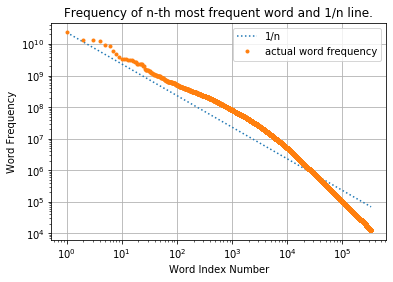

In [50]:
zipf_plot(P1w)

# Model: the Bigram Model

Even with billions of words of data, we won't have enough information to create a full joint probability model, where

$P(w_1 \ldots w_n) =  \Pi_{i=1}^n P(w_i \mid w_1 \ldots w_{i-1})$

Why not? Consider a 30-word sentence. We've probably never seen those words in that exact order before, so we have no information about $P(w_{30} \mid w_1 \ldots w_{29})$. But we are much more likely to have seen the two-word sequences that make up the sentence. We call these two-word sequences  **bigrams**. The **bigram model** says that the probability of each word depends on the immediately previous word but is independent of the words that came before that. It is less-wrong than the bag of words model. We can write an equation for the probability of a sequence of words (making the assumption that $w_0$ is a special "start" or "separator" symbol that we denote as `<S>`):
    
$P(w_1 \ldots w_n) = P(w_1 \mid \mbox{<S>}) \times P(w_2 \mid w_1) \times  \ldots P(w_n \mid w_{n-1}) = \Pi_{i=1}^{n} P(w_i \mid w_{i-1})$

The conditional probability of each word given the previous word is given by:

$P(w_i \mid w_{i-1}) = \frac{P(w_{i-1}w_i)}{P(w_{i-1})} $

That is, the bigram probability of the word and the previous word, divided by the unigram probability of the previous word. 

The bigram model can be thought of as a "multiple bags of words" model, where there are multiple bags, one for each distinct word, and a special bag marked `<S>`. (We assume that each sentence boundary in the text is also annotated with a `<S>`.) To build a model, take a text,
cut it up into slips of paper with two words on them, put each slip into the bag labelled with the first word on the slip.  To generate language from the model, first pick a slip from the bag labeled `<S>` and output the second word on the slip. Now pick a slip from the bag labeled with that second word, and output the second word on *that* slip. Continue in this manner.


The file `count_2w.txt` has bigram data in the form `"word1 word2 \t count"`. We'll load this into the bag `P2w`.

In [51]:
P2w = load_counts(open('count_2w.txt'))

In [52]:
len(P2w), sum(P2w.values())/1e9

(258437, 225.955251755)

Over a quarter million distinct two-word pairs, with a total count of 225 billion. Let's see the most common two-word sequences:

In [53]:
P2w.most_common(20)

[('of the', 2772205934),
 ('in the', 1735111785),
 ('to the', 1147345124),
 ('on the', 841095584),
 ('for the', 726714015),
 ('and the', 644282998),
 ('to be', 513603140),
 ('with the', 480181610),
 ('is a', 479118206),
 ('from the', 454051070),
 ('at the', 449390032),
 ('by the', 428337874),
 ('do not', 400755693),
 ('it is', 391172862),
 ('of a', 387456600),
 ('in a', 387077847),
 ('will be', 357181303),
 ('if you', 350999373),
 ('that the', 337117243),
 ('is the', 313123377)]

We'll use `Pwords2` for the probability of a word sequence in the bigram model, and `cPword` for the conditional probability of a word given the previous word. 

But we run into a problem: in `cPword` it is natural to divide by the probability of the previous word, but we don't want to divide by zero in the case where we haven't seen that word before. So we will use a **backoff model** that says if we don't have counts for both words, we'll fall back to the unigram probability of the word (ignoring the previous word).

In [54]:
def Pwords2(words, prev='<S>') -> float:
    """The probability of a sequence of words, using bigram data, given previous word."""
    return Π(cPword(w, (prev if (i == 0) else words[i-1]) )
             for (i, w) in enumerate(words))

def cPword(word, prev) -> float:
    """Conditional probability of word, given previous word."""
    bigram = prev + ' ' + word
    if P2w(bigram) > 0 and P1w(prev) > 0:
        return P2w(bigram) / P1w(prev)
    else: # Average the back-off value and zero.
        return P1w(word) 

In [55]:
P2w('of the')

0.012268827179134844

In [56]:
P2w('the of')

5.575887217554441e-06

We'll look at all 24 permutations of the words in  "this is a test" and compute the probability for each under the bigram model. We see that "this is a test" is the most probable permutation, and "this a is test" is the least probable, almost a million times less probable: 

In [57]:
sorted((Pwords2(t), sentence(t)) for t in permutations(tokens('this is a test')))[::-1]

[(3.472808344777707e-07, 'this is a test'),
 (1.127597078828602e-07, 'test this is a'),
 (6.965779368966287e-08, 'this test is a'),
 (3.156249379346401e-08, 'a test this is'),
 (2.2987584450049622e-08, 'is a test this'),
 (1.5938698734133065e-08, 'is a this test'),
 (1.340683369945385e-08, 'test is a this'),
 (1.306996404175386e-08, 'a test is this'),
 (4.2119901013695514e-09, 'a this is test'),
 (4.0586505617016795e-09, 'a this test is'),
 (2.225067906668548e-09, 'test a this is'),
 (2.2250679066685475e-09, 'this is test a'),
 (1.7086438151095857e-09, 'is this test a'),
 (9.36681886482603e-10, 'this a test is'),
 (7.464591940646502e-10, 'is this a test'),
 (6.790746260498466e-10, 'test is this a'),
 (9.442288029367219e-11, 'is test a this'),
 (7.210056993667689e-11, 'a is this test'),
 (6.959024970571533e-11, 'is test this a'),
 (1.0936134003445812e-11, 'this test a is'),
 (7.330795983439265e-12, 'test a is this'),
 (6.215026001209826e-12, 'a is test this'),
 (1.551284601334948e-12, '

Under the bag of words model, all permutations have the same probability (except for roundoff error in the least-significant digit):

In [58]:
sorted((Pwords(t), t) for t in permutations(tokens('this is a test')))[::-1]

[(2.9841954327098435e-11, ('this', 'test', 'is', 'a')),
 (2.9841954327098435e-11, ('this', 'test', 'a', 'is')),
 (2.9841954327098435e-11, ('this', 'is', 'test', 'a')),
 (2.9841954327098435e-11, ('test', 'this', 'is', 'a')),
 (2.9841954327098435e-11, ('test', 'this', 'a', 'is')),
 (2.9841954327098435e-11, ('test', 'is', 'this', 'a')),
 (2.9841954327098435e-11, ('test', 'a', 'this', 'is')),
 (2.9841954327098435e-11, ('is', 'this', 'test', 'a')),
 (2.9841954327098435e-11, ('is', 'test', 'this', 'a')),
 (2.9841954327098435e-11, ('a', 'test', 'this', 'is')),
 (2.984195432709843e-11, ('this', 'is', 'a', 'test')),
 (2.984195432709843e-11, ('this', 'a', 'test', 'is')),
 (2.984195432709843e-11, ('this', 'a', 'is', 'test')),
 (2.984195432709843e-11, ('test', 'is', 'a', 'this')),
 (2.984195432709843e-11, ('test', 'a', 'is', 'this')),
 (2.984195432709843e-11, ('is', 'this', 'a', 'test')),
 (2.984195432709843e-11, ('is', 'test', 'a', 'this')),
 (2.984195432709843e-11, ('is', 'a', 'this', 'test')),


# Task: Segmentation with a Bigram Model

Now let's re-do segmentation using a bigram model. To make `segment2`, we copy `segment`, and make sure to pass around the previous token, and to evaluate probabilities with `Pwords2` instead of `Pwords`.

In [59]:
@lru_cache(None)
def segment2(text, prev='<S>'): 
    "Return best segmentation of text; use bigram data." 
    if not text: 
        return []
    else:
        candidates = ([first] + segment2(rest, first) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=lambda words: Pwords2(words, prev))
    
def splits(text, start=0, end=20) -> Tuple[str, str]:
    """Return a list of all (first, rest) pairs; start <= len(first) <= L."""
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), end)+1)]

In [60]:
segment2('choosespain')

['choose', 'spain']

In [61]:
segment2('speedofart')

['speed', 'of', 'art']

For the following example, both `segment` and `segment2` perform perfectly:

In [62]:
tolkein = 'adrybaresandyholewithnothinginittositdownonortoeat'
sentence(segment(tolkein)), sentence(segment2(tolkein))

('a dry bare sandy hole with nothing in it to sit down on or to eat',
 'a dry bare sandy hole with nothing in it to sit down on or to eat')

But for the next example, `segment` gets three words wrong, while `segment2` only misses one word, `unregarded`, which is not in `P1w`.

In [63]:
adams = ('faroutintheunchartedbackwatersoftheunfashionableendofthewesternspiral' +
         'armofthegalaxyliesasmallunregardedyellowsun')
sentence(segment(adams))

'far out in the un chart ed back waters of the un fashionable end of the western spiral arm of the galaxy lies a small un regarded yellow sun'

In [64]:
sentence(segment2(adams))

'far out in the uncharted backwaters of the unfashionable end of the western spiral arm of the galaxy lies a small un regarded yellow sun'

In [65]:
'unregarded' in P1w

False

Conclusion? The bigram model is a little better, but these examples haven't demonstrated a large difference.  Even with hundreds of billions of words as data, we still don't have a complete model of English words.

# Theory: Evaluation

So far, we've got an intuitive feel for how this all works.  But we don't have any solid metrics that quantify the results.  Without metrics, we can't say if we are doing well, nor if a change is an improvement. In general,
when developing a program that relies on data to help make
predictions, it is good practice to divide your data into three sets:
<ol>
  <li> <b>Training set:</b> the data used to create our spelling
  model; this was the <tt>big.txt</tt> file.
  <li> <b>Development set:</b> a set of input/output pairs that we can
  use to rank the performance of our program as we are developing it.
  <li> <b>Test set:</b> another set of input/output pairs that we use
  to rank our program <i>after</i> we are done developing it.  The
  development set can't be used for this purpose&mdash;once the
  programmer has looked at the development test it is tainted, because
  the programmer might modify the program just to pass the development
  test.  That's why we need a separate test set that is only looked at
  after development is done.
</ol>

For this program, the training data is the word frequency BAG, the development set is the examples like `"choosespain"` that we have been playing with, and now we need a test set.

In [66]:
def test_segmenter(segmenter, tests):
    "Try segmenter on tests; report failures; return fraction correct."
    return sum([test_one_segment(segmenter, test) 
               for test in tests]), len(tests)

def test_one_segment(segmenter, test):
    words = tokens(test)
    result = segmenter(cat(words))
    correct = (result == words)
    if not correct:
        print('expected:', sentence(words))
        print('     got:', sentence(result))
    return correct

cat = ''.join

proverbs = ("""A little knowledge is a dangerous thing
  A man who is his own lawyer has a fool for his client
  All work and no play makes Jack a dull boy
  Better to remain silent and be thought a fool that to speak and remove all doubt;
  Do unto others as you would have them do to you
  Early to bed and early to rise, makes a man healthy, wealthy and wise
  Fools rush in where angels fear to tread
  Genius is one percent inspiration, ninety-nine percent perspiration
  If you lie down with dogs, you will get up with fleas
  Lightning never strikes twice in the same place
  Power corrupts; absolute power corrupts absolutely
  Here today, gone tomorrow
  See no evil, hear no evil, speak no evil
  Sticks and stones may break my bones, but words will never hurt me
  Take care of the pence and the pounds will take care of themselves
  Take care of the sense and the sounds will take care of themselves
  The bigger they are, the harder they fall
  The grass is always greener on the other side of the fence
  The more things change, the more they stay the same
  Those who do not learn from history are doomed to repeat it"""
  .splitlines())

In [67]:
test_segmenter(segment, proverbs)

expected: power corrupts absolute power corrupts absolutely
     got: power corrupt s absolute power corrupt s absolutely
expected: the grass is always greener on the other side of the fence
     got: the grass is always green er on the other side of the fence


(18, 20)

In [68]:
test_segmenter(segment2, proverbs)

(20, 20)

This confirms that both segmenters are  good, and that `segment2` is slightly better, getting 20 out of 20 examples right, compared to 18 out of 20 for `segment`. There is much more that can be done in terms of the variety of tests, and in measuring statistical significance.

# Theory and Practice: Smoothing

Here are some more test cases:


In [69]:
tests = ['this is the oligonucleotide test',
         'this is the neverbeforeseen test',
         'this is the zqbhjhsyefvvjqc test']

{test: Pwords2(tokens(test)) for test in tests}

{'this is the oligonucleotide test': 4.287506893716667e-14,
 'this is the neverbeforeseen test': 0.0,
 'this is the zqbhjhsyefvvjqc test': 0.0}

The issue here is the finality of a probability of zero.  Out of the three 15-letter words, it turns out that "oligonucleotide" is in the dictionary, but if it hadn't been, if somehow our corpus of words had missed it, then the probability of that whole phrase would have been zero.  It seems that is too strict; there must be some "real" words that are not in our dictionary, so we shouldn't give them probability zero.  There is also a question of likelyhood of being a "real" word.  It does seem that "neverbeforeseen" is more English-like than "zqbhjhsyefvvjqc", and so perhaps should have a higher probability.

We can address this by assigning a non-zero probability to words that are not in the dictionary.  This is even more important when it comes to multi-word phrases (such as bigrams), because many legitimate bigrams will not appear in the training data.

We can think of our probability model as being overly spiky; it has a spike of probability mass wherever a word or phrase occurs in the corpus.  What we would like to do is *smooth* over those spikes so that we get a model that does not depend so much on the details of our corpus. 

For example, Laplace was asked for an estimate of the probability of the sun rising tomorrow.  From past data, he knows that the sun has risen $n/n$ times for the last *n* days (with some uncertainty about the value of *n*), so the maximum liklihood estimator is probability 1.  But Laplace wanted to balance the observed data with the possibility that tomorrow, either the sun will rise or it won't, so he came up with an estimate of $(n + 1) / (n + 2)$.

<center>
    <img src="http://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Pierre-Simon_Laplace.jpg/220px-Pierre-Simon_Laplace.jpg" height=150 width=110> 
<br><i>What we know is little, and what we are ignorant of is immense.<i><br>&mdash; Pierre Simon Laplace (1749-1827)</i>
</center><p>
    

A generalization of Laplace's approach is called [additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing): we add a **pseudocount** (which does not have to be 1) to each of the outcomes we have seen so far, plus one more for the unseen outcomes. We will redefine `Bag` and `P1w` to use additive smoothing. This time, I can't have the `ProbabilityFunction` as a mixin, because I need to supply the psuedocount as an argument when the bag is constructed, and then use it within the probability function. Thus, I will redefine `Bag` as follows:


In [70]:
class Bag(Counter): 
    """A bag of words with a probability function using additive smoothing."""
    def __init__(self, elements=(), pseudocount=1):
        self.update(elements)
        self.pseudocount = pseudocount

    def __call__(self, outcome):
        """The probability of `outcome`, smoothed by adding pseudocount to each outcome."""
        if not hasattr(self, 'denominator'):
            self.denominator = sum(self.values()) +  self.pseudocount * (len(self) + 1)
        return (self[outcome] + self.pseudocount) / self.denominator

In [71]:
P1w = Bag(P1w)

Now an unknown word has a non-zero probability, as do sequences that contain unknown words, but known words still have higher probabilities:

In [72]:
P1w('neverbeforeseen')

1.7003201005861308e-12

In [73]:
{test: Pwords2(tokens(test)) for test in tests}

{'this is the oligonucleotide test': 4.287512523438411e-14,
 'this is the neverbeforeseen test': 8.033021050553851e-20,
 'this is the zqbhjhsyefvvjqc test': 8.033021050553851e-20}

There are many more advanced ways to do smoothing, but we won't cover them here.

There is one more issue to contend with that we will mention but not fix: the smallest positive 64-bit floating point number is about $10^{-323}$. That means that if we are trying to compute the probability of a long sequence of words, we will eventually reach a point where we get **floating point underflow** and the probability is incorrectly reported as zero. We see that this happens somewhere around a 100 word sequence, depending on the exact words:

In [74]:
{n: Pwords(sample(WORDS, n)) for n in range(70, 151, 10)}

{70: 1.1733110491887828e-219,
 80: 2.279383032662303e-258,
 90: 1.5643367062438602e-271,
 100: 7.120951572374323e-301,
 110: 1.67177e-319,
 120: 0.0,
 130: 0.0,
 140: 0.0,
 150: 0.0}

This problem can be addressed by adding logarithms rather than multiplying probabilities, or by re-scaling numbers when they get too small.

# Task: Secret Codes

Let's tackle one more task: decoding secret messages.  We'll start with the simplest of codes, a rotation cipher, sometimes called a shift cipher or a Caesar cipher (because this was state-of-the-art crypotgraphy in 100 BC).  First, a method to encode:

In [75]:
def rot(msg, n=13): 
    "Encode a message with a rotation (Caesar) cipher." 
    return encode(msg, alphabet[n:]+alphabet[:n])

def encode(msg, key): 
    "Encode a message with a substitution cipher." 
    table = str.maketrans(upperlower(alphabet), upperlower(key))
    return msg.translate(table) 

def upperlower(text): return text.upper() + text.lower()  

In [76]:
msg = 'This is a secret message.'

rot(msg, 1)

'Uijt jt b tfdsfu nfttbhf.'

In [77]:
rot(msg, 13)

'Guvf vf n frperg zrffntr.'

In [78]:
rot(rot(msg, 13), 13)

'This is a secret message.'

Decoding a Caesar cipher message is easy: try all 26 candidates, and find the one with the maximum `Pwords`:

In [79]:
def decode_rot(secret):
    "Decode a secret message that has been encoded with a rotation cipher."
    candidates = [tokens(rot(secret, i)) for i in range(26)]
    return sentence(max(candidates, key=Pwords))

In [80]:
secret = rot(msg, 17)

decode_rot(secret)

'this is a secret message'

Let's make it a bit harder.  When the secret message contains separate words, it is too easy to decode by guessing that the one-letter words are most likely "I" or "a".  So what if the encode routine squished all the letters together:

In [81]:
def squish_rot(msg, n=13):
    "Encode a message with a rotation (Caesar) cipher, keeping letters only." 
    return encode(cat(tokens(msg)), alphabet[n:]+alphabet[:n])

In [82]:
secret = squish_rot('Who knows the answer this time? Anyone? Anyone? Bueller?', 19)
secret

'pahdghplmaxtglpxkmablmbfxtgrhgxtgrhgxunxeexk'

That looks harder to decode. A decoder will have to try all rotations, then segment each rotation, and find the candidate with the best `Pwords`:

In [83]:
def decode_rot(secret):
    """Decode a secret message that has been encoded with a rotation cipher,
    and which has had all the non-letters squeezed out."""
    candidates = [segment(rot(secret, i)) for i in range(26)]
    return max(candidates, key=lambda msg: Pwords(msg))

In [84]:
sentence(decode_rot(secret))

'who knows the answer this time anyone anyone bu e ll er'

Almost right, but didn't quite get the proper name.

What about a general substitution cipher?  The problem is that there are $26! \approx 10^{26}$ substitution ciphers, and we can't enumerate all of them.  We would need to search through the space:  initially make some guess at a substitution, then swap two letters; if that looks better keep going, if not try something else.  This approach solves most substitution cipher problems, although it can take a few minutes on a message of length 100 words or so.

# What's Next?

What to do next?  Here are some options:
    
- **Spelling correction**: Use bigram or trigram context; make a model of spelling errors/edit distance; go beyond edit distance 2; make it more efficient
- **Evaluation**: Make a serious test suite; search for best parameters (e.g. $c_1, c_2, c_3$)
- **Smoothing**: Implement Kneser-Ney and/or Interpolation; do letter *n*-gram-based smoothing
- **Secret Codes**: Implement a search over substitution ciphers
- **Classification**: Given a corpus of texts, each with a classification label, write a classifier that will take a new text and return a label.  Examples: spam/no-spam; favorable/unfavorable; what author am I most like; reading level.
- **Clustering**: Group data by similarity.  Find synonyms/related words.
- **Parsing**: Representing nested structures rather than linear sequences of words.  relations between parts of the structure.  Implicit missing bits.  Inducing a grammar.
- **Meaning**: What semantic relations are meant by the syntactic relations?
- **Translation**: Using examples to transform one language into another.
- **Question Answering**: Using examples to transfer a question into an answer, either by retrieving a passage, or by synthesizing one.
- **Speech**: Dealing with analog audio signals rather than discrete sequences of characters.